## Tutorial - Visualize A shapefile

In [2]:
import os
# pandas package specialized for geospatial analysis
import geopandas as gpd
from matplotlib import pyplot as plt
# draw everything within the notebook
%matplotlib inline

We will visualize some shapes from the waterbodies of Cambodia. Geopandas is used to read in the .shp format and store as a table. A `GeoDataFrame` table always has attribute `geometry` in each of its row, which is a geometrical object, representable by `shapely` package.

In [4]:
# shapefile path
cambodia_waterbodies_path = '/home/dp/Documents/Projects/HydroViet/water-bodies-09-08-2016'
df = gpd.read_file(cambodia_waterbodies_path)

The first few rows of the table. Notice the `geometry` attribute (column) at the end of the table. That is the data we want to retrieve for visualization. Attribute `name` gives us a hint of what the object is about. 

In [5]:
df[:3]

,osm_id,waterway,landuse,natural,name,name_km,source,geometry
0,144567584,,,water,,,http://www.openstreetmap.la/downloads,"POLYGON ((102.5516487 13.6647897, 102.5518958 ..."
1,131780194,,,water,Casino Lake,,http://www.openstreetmap.la/downloads,"POLYGON ((102.5556661 13.6653339, 102.555683 1..."
2,131780192,,,water,,,http://www.openstreetmap.la/downloads,"POLYGON ((102.5563643 13.6690687, 102.5565199 ..."


Listing all the named objects give us the exact names.

In [6]:
set(df.name.tolist())

{'',
 'Ang Reservoir',
 'Baray Teuk Thla',
 'Basak',
 'Beng Thom',
 'Boeng Kirirom Lake',
 'Boeung Kam San',
 'Boeung Kan Seng',
 'Boeung Kropeur',
 'Boeung Ponna Reay',
 'Boeung Tomnop Tek Krolar (Secret Lake)',
 'Boeung Tompun',
 'Boeung Tonle Bati',
 'Boeung Tonle Sap',
 'Boeung Trabek',
 'Boeung Yeak Laom',
 'Casino Lake',
 'Jayatataka Baray',
 'Kampot River',
 "Phil's Fish Pond",
 'Phipot River',
 'Reservoir of Krang Serey',
 'Srah Srang',
 'Sras Srei',
 'Srey Snam Reservoir',
 'Stung Atay Reservoir',
 'Sông Giang Thành',
 'Tatai Dam',
 'Tei Teuk Pous (Hot Spring)',
 'Tonle Sap River',
 'Tonlee Saan',
 'Trapeang Daun Mea'}

Jupyter Notebook allows us to visualize directly inside the notebook without using any explicit drawing function.

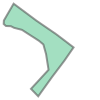

In [9]:
df.iloc[5].geometry

Besides visualizing row by row, the `GeoDataFrame` has the function `plot` which draws all of the geometrical objects at once, giving us the complete picture of the table.

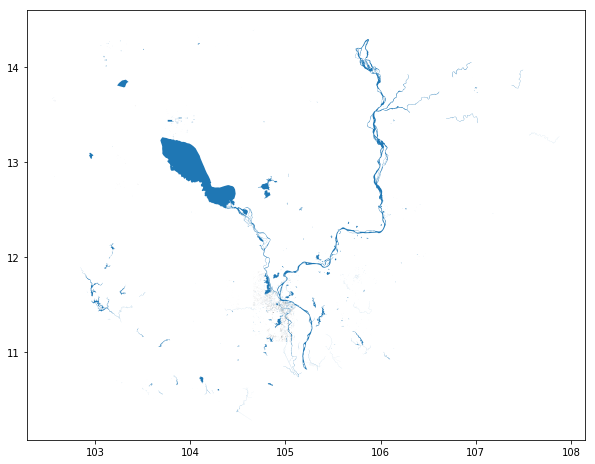

In [6]:
plt.rcParams['figure.figsize'] = 10, 10
df.plot();

Now we are interested in only the Tonle Sap lake, which is

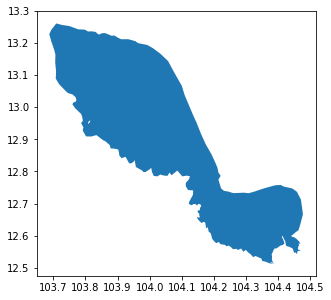

In [25]:
plt.rcParams['figure.figsize'] = 5, 5
tonlesap = df[df.name == 'Boeung Tonle Sap']
tonlesap.plot();

To overlay the Tonle Sap lake onto a raster, we go to Libra brower and take down three bands Red, NIR, and SWIR of the area.

In [78]:
# raster tile of Landsat-8
tile_landsat_paths = ['tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B4.TIF',
                        'tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B5.TIF',
                        'tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B6.TIF']

In [52]:
import numpy as np
import rasterio as rio
from rasterio.crs import CRS
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

`RasterIO` is a versatile Python package, built on top of GDAL, allow flexible raster and vector manipulations. By default it reads in GEOTIFF image formats.

In [81]:
with rio.open(tile_landsat_paths[0]) as src:
    red = src.read(1)
    crs = src.crs
    trans = src.transform
    bounds = src.bounds
with rio.open(tile_landsat_paths[1]) as src:
    nir = src.read(1)
with rio.open(tile_landsat_paths[2]) as src:
    swir = src.read(1)

Two important features of a raster everyone should remember, that is  `crs` and `transform`. The former define a coordinate type, and the latter defines what transformation in that coordinate. A georeferenced raster is defined iff those two parameters are available.

Raster bounds can be computed from `transform`

In [88]:
left, top = trans * (0, 0)
right, bottom = trans * (red.shape[1], red.shape[0])
print(left, bottom, right, top)
print(bounds)

227685.0 1321785.0 456015.0 1555215.0
BoundingBox(left=227685.0, bottom=1321785.0, right=456015.0, top=1555215.0)


Now we concatenate three bands to create a false RGB color image

In [99]:
false_color_raster = np.concatenate(
    [swir[..., np.newaxis], 
     nir[..., np.newaxis], 
     red[..., np.newaxis]], axis=-1)
false_color_raster = (false_color_raster / np.max(false_color_raster) * 255).astype(np.uint8)

In [16]:
# This function draw a list of geometry objects onto AX object
def plot_shapes(shapes, ax=None, overlay=False):

    cm = plt.get_cmap('jet')
    num_colors = len(shapes)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    mp = MultiPolygon(shapes)

    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for idx, p in enumerate(shapes):
        color = cm(1. * idx/num_colors)
        if overlay:
            patches.append(PolygonPatch(p, fc='none', ec='#555555', zorder=1))
        else:
            patches.append(PolygonPatch(p, fc=color, ec='#555555', alpha=.5, zorder=1))
    ax.add_collection(PatchCollection(patches, match_original=True))
    return ax

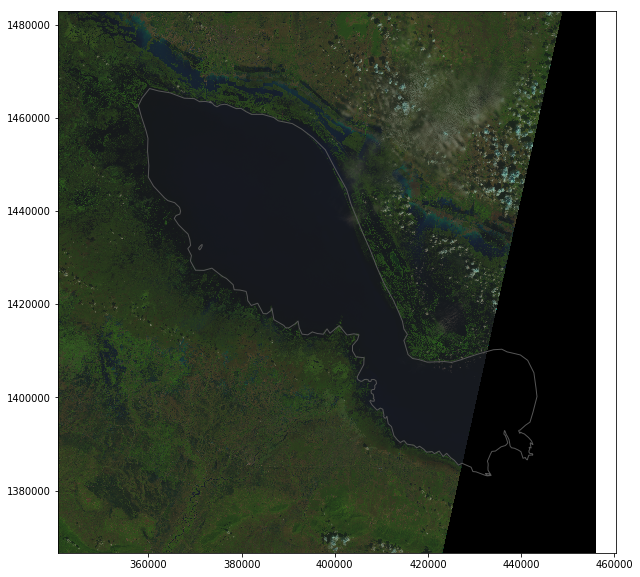

In [101]:
plt.rcParams['figure.figsize'] = 10, 10
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(false_color_raster, aspect=1.0, extent=[left, right, bottom, top])

tonlesap_shape = shape(transform_geom(df.crs, crs, mapping(tonlesap.geometry.values[0])))
ax = plot_shapes([tonlesap_shape], ax, True)

In [102]:
from skimage.transform import resize
from skimage import img_as_ubyte

In [103]:
downsampled = resize(false_color_raster, (1000, 1000))
downsampled = img_as_ubyte(downsampled)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
